## Traditional machine learning
Feature(s): Composition_Formula and Equilibrium_Pressure_25C
- combine both
- not sure how to do the Composition_Formula...

target: binary_heat
- binary class



In [2]:
import sys
import os
from sklearn.model_selection import cross_val_score
from sklearn.base import clone
from loguru import logger

logger.remove()
logger.add(sys.stderr, level="WARNING")
# Append the parent directory of your package to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..', '..')))

Read the dataset from the zip file

In [4]:
import pandas as pd
import numpy as np
import zipfile

path_to_dataset = 'Hydrides.csv'
csv_filename = 'Hydrides.csv'

# Open the file, Correct the encoding and sep if necessary
if path_to_dataset.endswith('.zip'):
    with zipfile.ZipFile(path_to_dataset, 'r') as z:
        # Open the CSV file within the ZIP file
        with z.open(csv_filename) as f:
            # Read the CSV file into a DataFrame
            df = pd.read_csv(f, sep=',', on_bad_lines='warn', index_col = 0)
else:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(path_to_dataset, sep=',', on_bad_lines='warn', index_col = 0)



In [9]:
df.Composition_Formula

0                    Th2Al
1                    Ti2Cu
2                    Zr2Cu
3                    Zr2Ni
4                    Mg2Ni
              ...         
422                VTiAlCr
423              VTiAlTaNb
424                TiVCrNb
425    Al0.1Ti0.3V0.3Nb0.3
426                  TiVNb
Name: Composition_Formula, Length: 427, dtype: object

In [3]:
from MLPipeline import MLmodel, BinTheTarget

Target = ['mp_bin']
Features = ['SMILES']
Feature_types = ['SMILES']
input = df

/home/lsmo/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def objectiveRandomForestClassifier(trial, model_instance):
    """
    Objective function for Optuna to minimize.
    """
    # Define hyperparameters to tune
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_categorical('max_depth', [None, 10, 20, 30, 40]),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 6),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }

    # Clone the model to ensure a fresh instance each trial
    model_clone = clone(model_instance.model)
    model_clone.set_params(**params)
    
    # Define the score metric
    scoring = 'accuracy'

    # Perform cross-validation
    scores = cross_val_score(model_clone, model_instance.X_train, model_instance.y_train, cv=model_instance.cv, scoring=scoring)

    # Return the average score across all folds
    return scores.mean()


def objectiveXGBClassifier(trial, model_instance):
    """
    Objective function for Optuna to minimize for XGBClassifier.
    """
    # Define hyperparameters to tune
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),  # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),  # L2 regularization
    }

    # Clone the model to ensure a fresh instance each trial
    model_clone = clone(model_instance.model)
    model_clone.set_params(**params)
    
    # Define the score metric
    scoring = 'accuracy'

    # Perform cross-validation
    scores = cross_val_score(model_clone, model_instance.X_train, model_instance.y_train, cv=model_instance.cv, scoring=scoring)

    # Return the average score across all folds
    return scores.mean()


In [5]:
MODEL_NAMES = ['RandomForestClassifier', 'XGBClassifier']
TARGETS = [[i] for i in Target ]
TRAIN_SIZES = [25, 50, 100, 200]

result = []
for seed in [1, 2, 3]:
    for model_name in MODEL_NAMES:
        for target in TARGETS:
            for train_size in TRAIN_SIZES:
                print(f'RUN: Model:{model_name} / Target:{target} / Train size:{train_size} / Seed:{seed}')
                
                if model_name == 'RandomForestClassifier':
                    objective = objectiveRandomForestClassifier
                elif model_name == 'XGBClassifier':
                    objective = objectiveXGBClassifier

                model = MLmodel(modelType=model_name, 
                df=input,
                randomSeed=seed,
                train_count = train_size,
                test_count = 50, 
                target=target, 
                features=Features, 
                hyperparameter_tuning=True,
                feature_types=Feature_types,
                optimization_method='optuna', 
                optimization_trials=10,
                objective=lambda trial: objective(trial, model)
                )

                model.train()
                eval, summary = model.evaluate()
                result.append({**summary, **eval, 'seed':seed})



RUN: Model:RandomForestClassifier / Target:['mp_bin'] / Train size:25 / Seed:1


[I 2024-09-17 10:30:16,374] A new study created in memory with name: no-name-c29c937c-5c65-47c5-a034-06df0416be47
[I 2024-09-17 10:30:17,639] Trial 0 finished with value: 0.6 and parameters: {'n_estimators': 238, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.6.
[I 2024-09-17 10:30:18,401] Trial 1 finished with value: 0.6 and parameters: {'n_estimators': 206, 'max_depth': 40, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.6.


RUN: Model:RandomForestClassifier / Target:['mp_bin'] / Train size:50 / Seed:1


[I 2024-09-17 10:30:19,129] A new study created in memory with name: no-name-b0b49357-a47d-444a-bb6b-659e08ed0204
[I 2024-09-17 10:30:19,755] Trial 0 finished with value: 0.36 and parameters: {'n_estimators': 105, 'max_depth': None, 'min_samples_split': 14, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.36.
[I 2024-09-17 10:30:20,466] Trial 1 finished with value: 0.5800000000000001 and parameters: {'n_estimators': 179, 'max_depth': 40, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}. Best is trial 1 with value: 0.5800000000000001.


RUN: Model:RandomForestClassifier / Target:['mp_bin'] / Train size:100 / Seed:1


[I 2024-09-17 10:30:21,129] A new study created in memory with name: no-name-8f681711-10c7-4001-b630-d6b5baa27c79
[I 2024-09-17 10:30:22,539] Trial 0 finished with value: 0.55 and parameters: {'n_estimators': 247, 'max_depth': 30, 'min_samples_split': 11, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.55.
[I 2024-09-17 10:30:23,626] Trial 1 finished with value: 0.5599999999999999 and parameters: {'n_estimators': 274, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False}. Best is trial 1 with value: 0.5599999999999999.


RUN: Model:RandomForestClassifier / Target:['mp_bin'] / Train size:200 / Seed:1


[I 2024-09-17 10:30:24,471] A new study created in memory with name: no-name-cfaef59c-6b86-4771-93c8-8df8d93522dd
[I 2024-09-17 10:30:25,696] Trial 0 finished with value: 0.615 and parameters: {'n_estimators': 270, 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.615.
[I 2024-09-17 10:30:26,382] Trial 1 finished with value: 0.6 and parameters: {'n_estimators': 137, 'max_depth': 30, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.615.


RUN: Model:XGBClassifier / Target:['mp_bin'] / Train size:25 / Seed:1


[I 2024-09-17 10:30:27,022] A new study created in memory with name: no-name-190adee1-bb4b-483a-ad29-58fc020a3f6a
[I 2024-09-17 10:30:27,352] Trial 0 finished with value: 0.64 and parameters: {'n_estimators': 157, 'max_depth': 15, 'learning_rate': 0.11471079194399908, 'subsample': 0.6029392616271096, 'colsample_bytree': 0.5845119158464867, 'gamma': 0.4750871454089408, 'reg_alpha': 2.2326883125121047e-07, 'reg_lambda': 2.187178221171122e-05}. Best is trial 0 with value: 0.64.
[I 2024-09-17 10:30:27,568] Trial 1 finished with value: 0.6000000000000001 and parameters: {'n_estimators': 88, 'max_depth': 12, 'learning_rate': 0.11579599388153286, 'subsample': 0.8702702573742346, 'colsample_bytree': 0.7700966092465831, 'gamma': 0.004359353661355968, 'reg_alpha': 1.9907408534847977e-07, 'reg_lambda': 6.458766065716105e-05}. Best is trial 0 with value: 0.64.


RUN: Model:XGBClassifier / Target:['mp_bin'] / Train size:50 / Seed:1


[I 2024-09-17 10:30:28,078] A new study created in memory with name: no-name-a155a4be-b804-43fc-8ee8-f269a9d58eb0
[I 2024-09-17 10:30:28,309] Trial 0 finished with value: 0.6 and parameters: {'n_estimators': 72, 'max_depth': 12, 'learning_rate': 0.02611736479856864, 'subsample': 0.5265157967288836, 'colsample_bytree': 0.6351829434771082, 'gamma': 0.0007061021425179472, 'reg_alpha': 0.0651353861689043, 'reg_lambda': 0.0005869250573191075}. Best is trial 0 with value: 0.6.
[I 2024-09-17 10:30:28,886] Trial 1 finished with value: 0.5199999999999999 and parameters: {'n_estimators': 194, 'max_depth': 7, 'learning_rate': 0.01030473487065091, 'subsample': 0.9740162690381511, 'colsample_bytree': 0.5814239058658749, 'gamma': 4.4565484836562416e-06, 'reg_alpha': 5.502432865936956e-08, 'reg_lambda': 0.22370042452888214}. Best is trial 0 with value: 0.6.


RUN: Model:XGBClassifier / Target:['mp_bin'] / Train size:100 / Seed:1


[I 2024-09-17 10:30:29,501] A new study created in memory with name: no-name-4af810c6-3afd-4d83-9219-10fdf997cf35
[I 2024-09-17 10:30:31,312] Trial 0 finished with value: 0.5900000000000001 and parameters: {'n_estimators': 265, 'max_depth': 10, 'learning_rate': 0.030297784787439493, 'subsample': 0.6371869081996986, 'colsample_bytree': 0.8387843528693494, 'gamma': 6.760558110470243e-05, 'reg_alpha': 0.012101392945229666, 'reg_lambda': 2.8204074534838605e-08}. Best is trial 0 with value: 0.5900000000000001.
[I 2024-09-17 10:30:32,371] Trial 1 finished with value: 0.55 and parameters: {'n_estimators': 256, 'max_depth': 11, 'learning_rate': 0.01323225904148682, 'subsample': 0.8789936061245353, 'colsample_bytree': 0.6458172738046266, 'gamma': 1.2634414649536586e-06, 'reg_alpha': 0.03355588779131695, 'reg_lambda': 0.0006317880969904225}. Best is trial 0 with value: 0.5900000000000001.


RUN: Model:XGBClassifier / Target:['mp_bin'] / Train size:200 / Seed:1


[I 2024-09-17 10:30:33,212] A new study created in memory with name: no-name-edbd09e7-d1c3-4507-b9d1-ceb29b7fa88a
[I 2024-09-17 10:30:33,608] Trial 0 finished with value: 0.6050000000000001 and parameters: {'n_estimators': 88, 'max_depth': 9, 'learning_rate': 0.23101197405734109, 'subsample': 0.6515651160638729, 'colsample_bytree': 0.5657126259858263, 'gamma': 0.017795555597068868, 'reg_alpha': 3.6473166383963113e-05, 'reg_lambda': 0.09500649218870191}. Best is trial 0 with value: 0.6050000000000001.
[I 2024-09-17 10:30:34,781] Trial 1 finished with value: 0.6199999999999999 and parameters: {'n_estimators': 232, 'max_depth': 14, 'learning_rate': 0.016809584069406032, 'subsample': 0.5744354798375424, 'colsample_bytree': 0.9471007553451555, 'gamma': 0.011437216215817463, 'reg_alpha': 0.010022007801850169, 'reg_lambda': 0.018349489422682642}. Best is trial 1 with value: 0.6199999999999999.


RUN: Model:RandomForestClassifier / Target:['mp_bin'] / Train size:25 / Seed:2


[I 2024-09-17 10:30:35,522] A new study created in memory with name: no-name-d2241b6b-abe3-4214-9c20-cf28e7dcda99
[I 2024-09-17 10:30:36,185] Trial 0 finished with value: 0.64 and parameters: {'n_estimators': 188, 'max_depth': 10, 'min_samples_split': 11, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.64.
[I 2024-09-17 10:30:36,633] Trial 1 finished with value: 0.64 and parameters: {'n_estimators': 112, 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.64.


RUN: Model:RandomForestClassifier / Target:['mp_bin'] / Train size:50 / Seed:2


[I 2024-09-17 10:30:37,236] A new study created in memory with name: no-name-bc3878ff-0ceb-47a9-8fe8-58f8a5fc4a42
[I 2024-09-17 10:30:37,617] Trial 0 finished with value: 0.5599999999999999 and parameters: {'n_estimators': 71, 'max_depth': 30, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.5599999999999999.
[I 2024-09-17 10:30:38,358] Trial 1 finished with value: 0.52 and parameters: {'n_estimators': 127, 'max_depth': None, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.5599999999999999.


RUN: Model:RandomForestClassifier / Target:['mp_bin'] / Train size:100 / Seed:2


[I 2024-09-17 10:30:38,950] A new study created in memory with name: no-name-37a8cf36-53ba-496d-ac7d-da364a82ac66
[I 2024-09-17 10:30:39,793] Trial 0 finished with value: 0.5599999999999999 and parameters: {'n_estimators': 184, 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.5599999999999999.
[I 2024-09-17 10:30:40,639] Trial 1 finished with value: 0.61 and parameters: {'n_estimators': 204, 'max_depth': None, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': False}. Best is trial 1 with value: 0.61.


RUN: Model:RandomForestClassifier / Target:['mp_bin'] / Train size:200 / Seed:2


[I 2024-09-17 10:30:41,456] A new study created in memory with name: no-name-7f9afdcc-bd47-47e3-9521-0ad7e5e22ba9
[I 2024-09-17 10:30:41,819] Trial 0 finished with value: 0.5050000000000001 and parameters: {'n_estimators': 56, 'max_depth': 30, 'min_samples_split': 5, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.5050000000000001.
[I 2024-09-17 10:30:42,946] Trial 1 finished with value: 0.55 and parameters: {'n_estimators': 189, 'max_depth': 30, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': True}. Best is trial 1 with value: 0.55.


RUN: Model:XGBClassifier / Target:['mp_bin'] / Train size:25 / Seed:2


[I 2024-09-17 10:30:43,554] A new study created in memory with name: no-name-73202ec6-9ab8-4a47-b274-c55c9f8271c4
[I 2024-09-17 10:30:43,940] Trial 0 finished with value: 0.64 and parameters: {'n_estimators': 198, 'max_depth': 3, 'learning_rate': 0.014533815108161397, 'subsample': 0.5274562614599917, 'colsample_bytree': 0.6702894376861639, 'gamma': 4.4660002748536034e-07, 'reg_alpha': 6.808717436117709e-08, 'reg_lambda': 0.008828075754526238}. Best is trial 0 with value: 0.64.
[I 2024-09-17 10:30:44,240] Trial 1 finished with value: 0.6 and parameters: {'n_estimators': 152, 'max_depth': 9, 'learning_rate': 0.05349743858380232, 'subsample': 0.5952702840160342, 'colsample_bytree': 0.8343445054620184, 'gamma': 2.888222586041742e-06, 'reg_alpha': 0.00039198601165324926, 'reg_lambda': 0.00010716467478903019}. Best is trial 0 with value: 0.64.


RUN: Model:XGBClassifier / Target:['mp_bin'] / Train size:50 / Seed:2


[I 2024-09-17 10:30:44,755] A new study created in memory with name: no-name-f6c50992-69fa-47f0-9772-058e1f749866
[I 2024-09-17 10:30:45,125] Trial 0 finished with value: 0.54 and parameters: {'n_estimators': 130, 'max_depth': 14, 'learning_rate': 0.01275847420583884, 'subsample': 0.5622104021874001, 'colsample_bytree': 0.6884422830599912, 'gamma': 0.0030453965097479263, 'reg_alpha': 4.433813111297283e-07, 'reg_lambda': 1.1922353885030904e-05}. Best is trial 0 with value: 0.54.
[I 2024-09-17 10:30:45,619] Trial 1 finished with value: 0.48 and parameters: {'n_estimators': 187, 'max_depth': 9, 'learning_rate': 0.013760531597971862, 'subsample': 0.6827504318588161, 'colsample_bytree': 0.6628548751652132, 'gamma': 0.00016383723570862917, 'reg_alpha': 3.916168823206231e-05, 'reg_lambda': 0.0002532544039283875}. Best is trial 0 with value: 0.54.


RUN: Model:XGBClassifier / Target:['mp_bin'] / Train size:100 / Seed:2


[I 2024-09-17 10:30:46,188] A new study created in memory with name: no-name-dc192f4d-e287-4bbe-8183-4077799ff4d3
[I 2024-09-17 10:30:46,813] Trial 0 finished with value: 0.53 and parameters: {'n_estimators': 226, 'max_depth': 5, 'learning_rate': 0.13513940887586387, 'subsample': 0.9802471586908892, 'colsample_bytree': 0.551534498395338, 'gamma': 0.0023388512078556466, 'reg_alpha': 0.16686487367744976, 'reg_lambda': 0.007670967038541209}. Best is trial 0 with value: 0.53.
[I 2024-09-17 10:30:47,459] Trial 1 finished with value: 0.58 and parameters: {'n_estimators': 254, 'max_depth': 6, 'learning_rate': 0.09717718959511154, 'subsample': 0.8501570001673245, 'colsample_bytree': 0.7057965447773745, 'gamma': 0.288816921672585, 'reg_alpha': 2.390909075636635e-05, 'reg_lambda': 0.00875935754761242}. Best is trial 1 with value: 0.58.


RUN: Model:XGBClassifier / Target:['mp_bin'] / Train size:200 / Seed:2


[I 2024-09-17 10:30:48,223] A new study created in memory with name: no-name-696b2ec3-f7b5-4844-980c-182ecfa6fc60
[I 2024-09-17 10:30:49,218] Trial 0 finished with value: 0.595 and parameters: {'n_estimators': 283, 'max_depth': 14, 'learning_rate': 0.2665929373161312, 'subsample': 0.6184421818941288, 'colsample_bytree': 0.8535429930211516, 'gamma': 1.3336864188458557e-07, 'reg_alpha': 0.030479901800047345, 'reg_lambda': 3.0836027934462384e-06}. Best is trial 0 with value: 0.595.
[I 2024-09-17 10:30:49,675] Trial 1 finished with value: 0.585 and parameters: {'n_estimators': 86, 'max_depth': 6, 'learning_rate': 0.04601170183005981, 'subsample': 0.5804476193175652, 'colsample_bytree': 0.7928150018107132, 'gamma': 4.178521531355553e-08, 'reg_alpha': 1.2437248834133802e-05, 'reg_lambda': 0.00011334199500056175}. Best is trial 0 with value: 0.595.


RUN: Model:RandomForestClassifier / Target:['mp_bin'] / Train size:25 / Seed:3


[I 2024-09-17 10:30:50,356] A new study created in memory with name: no-name-a7324873-678b-44e7-a3cf-088ef4ea650d
[I 2024-09-17 10:30:51,055] Trial 0 finished with value: 0.32 and parameters: {'n_estimators': 131, 'max_depth': 40, 'min_samples_split': 12, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.32.
[I 2024-09-17 10:30:51,578] Trial 1 finished with value: 0.27999999999999997 and parameters: {'n_estimators': 135, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.32.


RUN: Model:RandomForestClassifier / Target:['mp_bin'] / Train size:50 / Seed:3


[I 2024-09-17 10:30:52,221] A new study created in memory with name: no-name-e6d54860-a5a5-4e9b-9e05-b2c498fb93e2
[I 2024-09-17 10:30:53,211] Trial 0 finished with value: 0.52 and parameters: {'n_estimators': 168, 'max_depth': 40, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.52.
[I 2024-09-17 10:30:53,973] Trial 1 finished with value: 0.5 and parameters: {'n_estimators': 137, 'max_depth': 40, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.52.


RUN: Model:RandomForestClassifier / Target:['mp_bin'] / Train size:100 / Seed:3


[I 2024-09-17 10:30:54,699] A new study created in memory with name: no-name-bed17344-5172-4bd4-9c6c-b40741e8acc9
[I 2024-09-17 10:30:55,528] Trial 0 finished with value: 0.4999999999999999 and parameters: {'n_estimators': 134, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.4999999999999999.
[I 2024-09-17 10:30:55,908] Trial 1 finished with value: 0.53 and parameters: {'n_estimators': 91, 'max_depth': 40, 'min_samples_split': 13, 'min_samples_leaf': 6, 'max_features': 'log2', 'bootstrap': False}. Best is trial 1 with value: 0.53.


RUN: Model:RandomForestClassifier / Target:['mp_bin'] / Train size:200 / Seed:3


[I 2024-09-17 10:30:56,587] A new study created in memory with name: no-name-dadbf24b-e1c5-4c24-bf99-a741e3e3b7b1
[I 2024-09-17 10:30:57,542] Trial 0 finished with value: 0.595 and parameters: {'n_estimators': 154, 'max_depth': None, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.595.
[I 2024-09-17 10:30:58,713] Trial 1 finished with value: 0.64 and parameters: {'n_estimators': 231, 'max_depth': 40, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 0.64.


RUN: Model:XGBClassifier / Target:['mp_bin'] / Train size:25 / Seed:3


[I 2024-09-17 10:30:59,338] A new study created in memory with name: no-name-50f94065-83bf-4b18-8925-41ef1a0f9c60
[I 2024-09-17 10:30:59,559] Trial 0 finished with value: 0.32 and parameters: {'n_estimators': 73, 'max_depth': 5, 'learning_rate': 0.10554136443610218, 'subsample': 0.895757195427945, 'colsample_bytree': 0.695815675237164, 'gamma': 7.104620658062965e-06, 'reg_alpha': 1.474931877940059e-08, 'reg_lambda': 4.1105890826803005e-06}. Best is trial 0 with value: 0.32.
[I 2024-09-17 10:31:00,029] Trial 1 finished with value: 0.27999999999999997 and parameters: {'n_estimators': 255, 'max_depth': 5, 'learning_rate': 0.039162629443027515, 'subsample': 0.8331358998443807, 'colsample_bytree': 0.5878518455597901, 'gamma': 8.55966709511837e-06, 'reg_alpha': 1.7217615424463675e-06, 'reg_lambda': 0.0006202759065836316}. Best is trial 0 with value: 0.32.


RUN: Model:XGBClassifier / Target:['mp_bin'] / Train size:50 / Seed:3


[I 2024-09-17 10:31:00,504] A new study created in memory with name: no-name-ac8884e7-ea77-4186-8da5-4eec03ba5dde
[I 2024-09-17 10:31:01,018] Trial 0 finished with value: 0.44000000000000006 and parameters: {'n_estimators': 228, 'max_depth': 8, 'learning_rate': 0.18012426507985002, 'subsample': 0.8549773159025045, 'colsample_bytree': 0.8523477333262851, 'gamma': 8.064244669209317e-08, 'reg_alpha': 1.489429418282184e-08, 'reg_lambda': 0.00020443885313896386}. Best is trial 0 with value: 0.44000000000000006.
[I 2024-09-17 10:31:01,518] Trial 1 finished with value: 0.42000000000000004 and parameters: {'n_estimators': 273, 'max_depth': 9, 'learning_rate': 0.16016055482821373, 'subsample': 0.7875955876517116, 'colsample_bytree': 0.9072205788637657, 'gamma': 1.1861263609670166e-05, 'reg_alpha': 5.8572403852175864e-05, 'reg_lambda': 2.208944770041574e-08}. Best is trial 0 with value: 0.44000000000000006.


RUN: Model:XGBClassifier / Target:['mp_bin'] / Train size:100 / Seed:3


[I 2024-09-17 10:31:02,107] A new study created in memory with name: no-name-0ad7b8b7-a024-450d-9816-4eb4df8bd93f
[I 2024-09-17 10:31:03,184] Trial 0 finished with value: 0.52 and parameters: {'n_estimators': 295, 'max_depth': 14, 'learning_rate': 0.010370357012752207, 'subsample': 0.5018839618780427, 'colsample_bytree': 0.8368310982649967, 'gamma': 4.139198700225397e-08, 'reg_alpha': 6.322263318188044e-07, 'reg_lambda': 1.61351082701251e-05}. Best is trial 0 with value: 0.52.
[I 2024-09-17 10:31:03,432] Trial 1 finished with value: 0.5399999999999999 and parameters: {'n_estimators': 52, 'max_depth': 14, 'learning_rate': 0.08650600080760024, 'subsample': 0.8581961142295029, 'colsample_bytree': 0.8440641366411267, 'gamma': 0.4940669050573746, 'reg_alpha': 0.12327575321017427, 'reg_lambda': 5.9064177957706455e-05}. Best is trial 1 with value: 0.5399999999999999.


RUN: Model:XGBClassifier / Target:['mp_bin'] / Train size:200 / Seed:3


[I 2024-09-17 10:31:04,142] A new study created in memory with name: no-name-dec3a4a0-3c97-47d6-b9e4-fb59f52f65d1
[I 2024-09-17 10:31:05,176] Trial 0 finished with value: 0.615 and parameters: {'n_estimators': 261, 'max_depth': 11, 'learning_rate': 0.0979713848253234, 'subsample': 0.765305959013165, 'colsample_bytree': 0.5029692531462356, 'gamma': 0.0002727872078821265, 'reg_alpha': 1.2231230414746552e-08, 'reg_lambda': 6.121363588373275e-06}. Best is trial 0 with value: 0.615.
[I 2024-09-17 10:31:05,842] Trial 1 finished with value: 0.5950000000000001 and parameters: {'n_estimators': 103, 'max_depth': 12, 'learning_rate': 0.020792183519201944, 'subsample': 0.8755065250150054, 'colsample_bytree': 0.6640125026937007, 'gamma': 0.028766032103909534, 'reg_alpha': 0.02839400663322438, 'reg_lambda': 0.0016867432907019995}. Best is trial 0 with value: 0.615.


Some information about the dataset such as the splitting, wrong smiles, total number of samples.

In [6]:
df = pd.DataFrame(result)
display(df)
df.to_csv('H2storage_metalHydrides_traditional_ml.csv')

,modeltype,target,train_size,trues,preds,model_params,accuracy,f1_micro,f1_macro,kappa,seed
0,RandomForestClassifier,[mp_bin],25,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.46,0.46,0.315068,0.000000,1
1,RandomForestClassifier,[mp_bin],50,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, ...","[1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.54,0.54,0.524597,0.111283,1
2,RandomForestClassifier,[mp_bin],100,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, ...","[1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, ...","{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.58,0.58,0.571603,0.183515,1
3,RandomForestClassifier,[mp_bin],200,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, ...","[0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, ...","{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.64,0.64,0.637681,0.275362,1
4,XGBClassifier,[mp_bin],25,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, ...","[1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, ...","{'objective': 'binary:logistic', 'base_score':...",0.58,0.58,0.571603,0.183515,1
5,XGBClassifier,[mp_bin],50,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, ...","[1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","{'objective': 'binary:logistic', 'base_score':...",0.58,0.58,0.575758,0.178404,1
6,XGBClassifier,[mp_bin],100,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, ...","[1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, ...","{'objective': 'binary:logistic', 'base_score':...",0.58,0.58,0.579832,0.167987,1
7,XGBClassifier,[mp_bin],200,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, ...","[1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, ...","{'objective': 'binary:logistic', 'base_score':...",0.68,0.68,0.680000,0.364070,1
8,RandomForestClassifier,[mp_bin],25,"[0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, ...","[1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.36,0.36,0.264706,-0.122020,2
9,RandomForestClassifier,[mp_bin],50,"[0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, ...","[0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, ...","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.48,0.48,0.480000,-0.014041,2


Text(0.5, 0.98, 'Random Forrest & XGB - MeltingPoint_molecules')

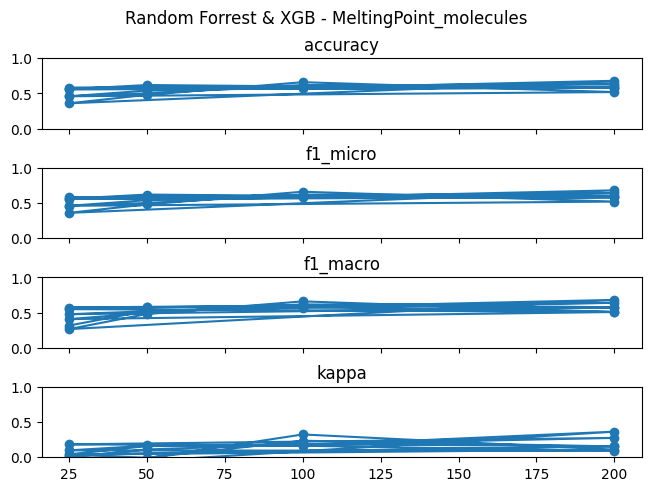

In [7]:
import matplotlib.pyplot as plt

METRICS = ['accuracy','f1_micro','f1_macro', 'kappa']
fig, ax = plt.subplots(len(METRICS), 1, sharex=True, layout = 'constrained')
ax = ax.flatten()

for i, metric in enumerate(METRICS):
    ax[i].plot(df['train_size'], df[metric], marker = 'o')
    ax[i].set_title(metric)
    ax[i].set_ylim(0,1)

fig.suptitle('Random Forrest & XGB - H2storage_metalHydrides')